_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [4]:
import pandas_profiling
train.profile_report()

In [5]:
from sklearn.impute import SimpleImputer
def cleanify():
    train['Facility_Type'] = train['Facility_Type'].fillna('Restaurant')
    train['Inspection_Type'] = train['Inspection_Type'].fillna('Canvass')
    train['Risk'] = train['Risk'].fillna('Risk 1 (High)')
    train['Violations'] = train['Violations'].fillna('none')
    train['License_#'] = SimpleImputer(train['License_#'], strategy='most_frequent')
    train['Latitude'] = SimpleImputer(train['Latitude'])
    train['Longitude'] = SimpleImputer(train['Longitude'])
    train['Zip'] = SimpleImputer(train['Zip'], strategy='most_frequent')
cleanify()

In [6]:
train.columns.tolist()

['Inspection_ID',
 'DBA_Name',
 'AKA_Name',
 'License_#',
 'Facility_Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection_Date',
 'Inspection_Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location',
 'Fail']

In [7]:
test.columns.tolist()

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location',
 'Fail']

In [8]:
# Spaces instead of underscores? that's just evil!
columns = {'Inspection ID':'Inspection_ID',
 'DBA Name':'DBA_Name',
 'AKA Name':'AKA_Name',
 'License #':'License_#',
 'Facility Type':'Facility_Type',
 'Inspection Date':'Inspection_Date',
 'Inspection Type':'Inspection_Type',
}
test = test.rename(columns=columns)

In [9]:
target = 'Fail'
features = [
    'Inspection_ID',
 'DBA_Name',
 'License_#',
 'Facility_Type',
 'Risk',
 'Zip',
 'Inspection_Date',
 'Inspection_Type',
 'Violations',
 'Latitude',
 'Longitude'
]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [10]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler

X_train.isna().sum()

Inspection_ID      0
DBA_Name           0
License_#          0
Facility_Type      0
Risk               0
Zip                0
Inspection_Date    0
Inspection_Type    0
Violations         0
Latitude           0
Longitude          0
dtype: int64

In [11]:
X_train.head()

,Inspection_ID,DBA_Name,License_#,Facility_Type,Risk,Zip,Inspection_Date,Inspection_Type,Violations,Latitude,Longitude
0,2088270,"TOM YUM RICE & NOODLE, INC.","SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
1,555268,FILLING STATION & CONVENIENCE STORE,"SimpleImputer(add_indicator=False, copy=True, ...",Grocery Store,Risk 3 (Low),"SimpleImputer(add_indicator=False, copy=True, ...",2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
2,1751394,A P DELI,"SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...","SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,"SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 2 (Medium),"SimpleImputer(add_indicator=False, copy=True, ...",2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
4,453326,MORRILL,"SimpleImputer(add_indicator=False, copy=True, ...",School,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."


In [12]:
model = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=200)
)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA_Name', 'License_#', 'Facility_Type',
                                      'Risk', 'Zip', 'Inspection_Date',
                                      'Inspection_Type', 'Violations',
                                      'Latitude', 'Longitude'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA_Name',
                                          'data_type': dtype('O'),
                                          'mapping': TOM YUM RICE & NOODLE, INC.                  1
FILLING S...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                            

In [14]:
model.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['DBA_Name', 'License_#', 'Facility_Type', 'Risk', 'Zip',
                      'Inspection_Date', 'Inspection_Type', 'Violations',
                      'Latitude', 'Longitude'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value',
                mapping=[{'col': 'DBA_Name', 'data_type': dtype('O'),
                          'mapping': TOM YUM RICE & NOODLE, INC.                  1
 FILLING STATION  & CONVENIENCE  STORE        2
 A P DELI                                     3
 FRANK'S CHICAGO S...
                          'mapping': SimpleImputer(add_indicator=False, copy=True, fill_value=None,\n              missing_values=0       -87.644755\n1       -87.683603\n2       -87.575054\n3       -87.707125\n4              NaN\n           ...    \n51911   -87.641120\n51912   -87.620308\n51913   -87.614611\n51914   -87.756750\n51915   -87.622572\nName: Longitude, Length: 51916, dtype: float64,\n        

In [18]:
param_distributions = {
    'randomforestclassifier__n_estimators': randint(20, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25,  None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_split': range(2, 10),
    'randomforestclassifier__min_samples_leaf': range(1, 10)
}

search = RandomizedSearchCV( 
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=10,
    scoring='roc_auc',
    verbose=10,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.661), total=   4.4s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.912, test=0.706), total=   3.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.706), total=   2.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.728), total=   2.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.914, test=0.735), total=   2.6s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.912, test=0.746), total=   3.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.1s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.912, test=0.736), total=   2.6s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.0s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.748), total=   2.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.3s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.735), total=   2.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.3s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.25307017888122696, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=69, score=(train=0.913, test=0.718), total=   2.6s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.12935937616990079, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_estimators=117 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.12935937616990079, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_estimators=117, score=(train=0.774, test=0.656), total=   2.9s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.12935937616990079, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=9, randomforestclass

[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.7296002157924883, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=8, randomforestclassifier__n_estimators=390, score=(train=0.958, test=0.749), total=  26.7s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.7296002157924883, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=8, randomforestclassifier__n_estimators=390 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.7296002157924883, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=8, randomforestclassifier__n_estimators=390, score=(train=0.959, test=0.746), total=  26.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.7296002157924883, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=8, randomforestcl

[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.20527493229674976, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=439, score=(train=0.937, test=0.710), total=  13.0s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.20527493229674976, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=439 
[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.20527493229674976, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=439, score=(train=0.937, test=0.732), total=  12.5s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.20527493229674976, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassi

[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.1522160199719309, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=143, score=(train=0.950, test=0.734), total=   4.7s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.1522160199719309, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=143 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.1522160199719309, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=143, score=(train=0.948, test=0.710), total=   4.1s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.7876329809211629, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=4, randomforestclas

[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.5772771633936283, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=7, randomforestclassifier__n_estimators=291, score=(train=0.960, test=0.752), total=  16.6s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.5772771633936283, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=7, randomforestclassifier__n_estimators=291 
[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.5772771633936283, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=7, randomforestclassifier__n_estimators=291, score=(train=0.958, test=0.745), total=  16.2s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.5772771633936283, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=7, randomforestclassifier

[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.702772200809229, randomforestclassifier__min_samples_leaf=7, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_estimators=316, score=(train=0.956, test=0.717), total=  20.4s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.702772200809229, randomforestclassifier__min_samples_leaf=7, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_estimators=316 
[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.702772200809229, randomforestclassifier__min_samples_leaf=7, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_estimators=316, score=(train=0.955, test=0.720), total=  20.1s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.702772200809229, randomforestclassifier__min_samples_leaf=7, randomforestclassifier__min_samples_split=9, randomforestclassifier__n_

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 22.3min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['DBA_Name',
                                                                   'License_#',
                                                                   'Facility_Type',
                                                                   'Risk',
                                                                   'Zip',
                                                                   'Inspection_Date',
                                                                   'Inspection_Type',
                                                                   'Violations',
                                                                   'Latitude',
                                                                   'Longitude'],
                     

In [50]:
model = search.best_estimator_
model

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA_Name', 'License_#', 'Facility_Type',
                                      'Risk', 'Zip', 'Inspection_Date',
                                      'Inspection_Type', 'Violations',
                                      'Latitude', 'Longitude'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA_Name',
                                          'data_type': dtype('O'),
                                          'mapping': TOM YUM RICE & NOODLE, INC.                  1
FILLING S...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features=0.7876329809211629,
                                        max_leaf_nodes=None,


In [22]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.predict_proba(X_test)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6048949101534385


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

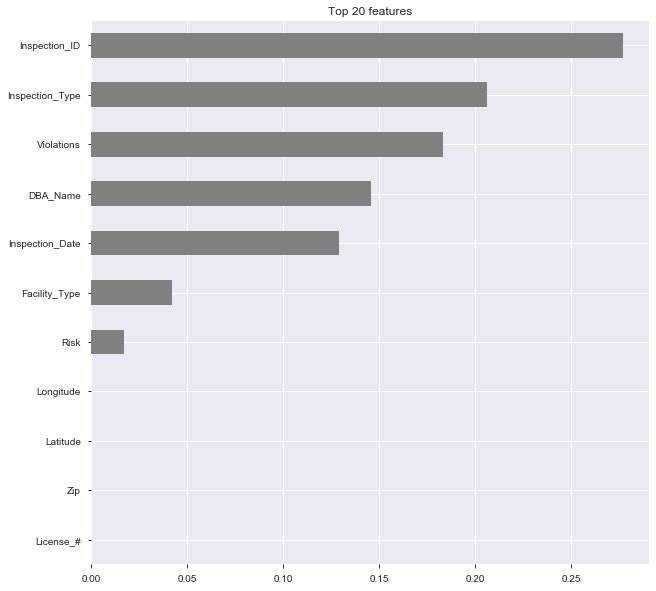

In [28]:
import matplotlib.pyplot as plt
rf = model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)


n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [54]:
X_train.head()

,Inspection_ID,DBA_Name,License_#,Facility_Type,Risk,Zip,Inspection_Date,Inspection_Type,Violations,Latitude,Longitude
0,2088270,"TOM YUM RICE & NOODLE, INC.","SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
1,555268,FILLING STATION & CONVENIENCE STORE,"SimpleImputer(add_indicator=False, copy=True, ...",Grocery Store,Risk 3 (Low),"SimpleImputer(add_indicator=False, copy=True, ...",2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
2,1751394,A P DELI,"SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...","SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,"SimpleImputer(add_indicator=False, copy=True, ...",Restaurant,Risk 2 (Medium),"SimpleImputer(add_indicator=False, copy=True, ...",2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."
4,453326,MORRILL,"SimpleImputer(add_indicator=False, copy=True, ...",School,Risk 1 (High),"SimpleImputer(add_indicator=False, copy=True, ...",2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","SimpleImputer(add_indicator=False, copy=True, ...","SimpleImputer(add_indicator=False, copy=True, ..."


In [56]:
import shap
         
explainer = shap.TreeExplainer(model)

def explain(row_number):
    positive_class = 'Fail'
    positive_class_index = 1
    
    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = row
    
    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba
    
    # Show prediction & probability
    print(f'The model predicts this loan is {pred}, with {pred_proba:.0f}% probability.')
    

    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)
    
    # Get top 3 "pros & cons"
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index
   
    # Show top 3 reasons for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')
    
    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0] 
    print(f'- {feature_name} is {feature_value}.')
    
    
    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row
    )
explain(27)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [79]:
encoder = ce.OrdinalEncoder(cols = ['Risk'])
X_test = encoder.fit_transform(X_test)
X_test['Risk_Encoded'] = risk_encoded
# X_test.drop(columns='Risk_encoded', inplace=True)
X_test.head()
feature = 'Risk'

isolated = pdp_isolate(
    model = model,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.ylim(-0.5, 0.5);

ValueError: Unexpected input dimension 12, expected 11